* The empty ipynb for you to start from in the repo: https://github.com/grantmlong/itds2019

# Setting the stage

In [1]:
import sys
sys.version # 3.6

'3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
# if running on colab, pytorch is already installed.
# if running locally, conda or pip install this in your conda environment:
# conda install pytorch torchvision -c pytorch
# OR
# pip3 install torch torchvision

# I'll be assuming python >=3.6 and torch 1.0.1 which are the colab defaults.

In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
print(torch.__version__) # 1.0.1

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

1.0.0.dev20181130


# Torch and autograd basics

Torch is a package that defines vectors, matrices, or in general "tensors". If you know numpy, you will not be surprised by any of these:

In [4]:
a = torch.ones(3,3)
a

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [5]:
b = torch.arange(9).float().view(3,3)
b

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [6]:
(a+b)**2

tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

In [7]:
b[:,0]

tensor([0., 3., 6.])

In [8]:
a.zero_() # operations with an underscore modify the Tensor in place.
a

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

You can slice and dice tensors and they have roughly all tensor operations you expect equivalently to numpy, but with a bit more low level control. If you need more intro: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py

So what's the big deal about pytorch?

**autograd = automatic differentiation**.

Every `torch.Tensor`, let's say `x`, has an important flag `requires_grad`. If this flag is set to True, pytorch will keep track of the graph of operations that happen with this tensor.
When we finally arrive at some output (a scalar variable based on a sequence of operations on `x`), we can call `.backward()` on this output, to compute the gradient `d(output) / dx`. This gradient will end up in `x.grad`.

In [9]:
x = torch.randn(2,2, requires_grad=True)
x

tensor([[-1.1510,  0.3353],
        [-2.1138,  0.8261]], requires_grad=True)

In [10]:
y=(x**2 + x)
z = y.sum()
z

tensor(4.4843, grad_fn=<SumBackward0>)

We know from high school math that the derivative `dz / dx[i,j]` = 2*x +1

In [11]:
z.backward()
x.grad

tensor([[-1.3020,  1.6707],
        [-3.2275,  2.6521]])

In [12]:
2*x+1

tensor([[-1.3020,  1.6707],
        [-3.2275,  2.6521]], grad_fn=<AddBackward0>)

What about the intermediate variable y? Does it require a gradient?

In [13]:
y.requires_grad

True

However the gradient of y is not exposed, since it is an intermediary variable, the result of an operation on leaf variables. Leaf variables are inputs to the operations: the data X or the `Parameter`s of a neural network.

More about autograd in the tutorial https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py and the docs https://pytorch.org/docs/stable/autograd.html

In the lecture we talked about how derivatives and backpropagation (based on the chain rule of differentiation) play a central role in deep learning. You can now start to see how this autograd will be massively powerful to define neural networks with weights `W` and optimize them based on the gradients in `W.grad`.

# Linear regression on a toy problem

Let's try this for a simple linear mapping `y = W x `, where we want to optimize W:

In [14]:
torch.manual_seed(23801)
x1 = torch.Tensor([1, 2, 3, -3, -2])
y = torch.Tensor ([3, 6, 9, -9, -6]).view(5,1)
x2 = torch.randn(5)
x = torch.stack([x1, x2], dim=1) # 5 x 2 input. 5 datapoints, 2 dimensions.
W = torch.randn(1,2, requires_grad=True)
# we start W at random initialization, the gradient will point us in the right direction.
print('x:\n', x)
print('y:\n', y)
print('W at random initialization: ', W)

x:
 tensor([[ 1.0000, -0.9665],
        [ 2.0000, -0.4228],
        [ 3.0000,  0.2336],
        [-3.0000, -1.6804],
        [-2.0000,  1.6508]])
y:
 tensor([[ 3.],
        [ 6.],
        [ 9.],
        [-9.],
        [-6.]])
W at random initialization:  tensor([[-0.4394, -0.2656]], requires_grad=True)


Take a look at x and y. What is the (linear) relationship?

A: clearly the true relationship is y  = 3*x1 + 0 * x2.  So we can see that the optimal W = [3,0]

Note that in notation of previous lecture 5, 
* the features are still $X_1, X_2$ concatenated as columns (rows = datapoints)
* $W = [\beta_1, \beta_2]$
* there is no $\beta_0$ or "intercept term" or in deep learning speak, "bias" term

In [15]:
ypred = x @ W.t() # matrix multiply; (N x 2) * (2 x 1) -> N x 1
print('ypred:\n', ypred)
loss = ((ypred-y)**2).mean() # mean squared error = MSE
print('mse loss: ', loss.item())
loss.backward()
print('W grad:\n', W.grad)
# let's move W in that direction
W.data -= 0.1 * W.grad
# Now we will reset the gradient to zero.
# Do an in-place operation tensor operation `.zero_()` on the gradient W.grad.
W.grad.zero_()
print('W:\n', W)

ypred:
 tensor([[-0.1827],
        [-0.7665],
        [-1.3802],
        [ 1.7644],
        [ 0.4404]], grad_fn=<MmBackward>)
mse loss:  64.20298767089844
W grad:
 tensor([[-37.2121,  -1.5780]])
W:
 tensor([[ 3.2818, -0.1078]], requires_grad=True)


You can re-execute this cell above a couple of times and see how W goes close towards the optimal value of `[3,0]` (it may be a bit off because of the added noise).

torch defines `Module`s which do two things: (a) they contain the learnable weight, and (b) define how they operate on an input tensor to give an output.
In this case this would be a `Linear` layer, reducing 2D datapoints `x` to 1D output `y`.

Ok doing this manually gives you insight what happens down to the gradienst. But usually we do not do these things manually, it would become very cumbersome if the net becomes more complex than the simple linear layer. pytorch gives us primitives to do the same: `net.zero_grad()` to clear the gradients, and for optimization you can do `optimizer.step()` to do a step of SGD.
Again we will do 1 epoch.

In [16]:
linear = nn.Linear(2,1, bias=False)
linear.weight.data.copy_(W) # we re-initialize the linear layer with the W we just found
ypred = linear(x)
ypred

tensor([[ 3.3860],
        [ 6.6092],
        [ 9.8203],
        [-9.6644],
        [-6.7416]], grad_fn=<MmBackward>)

Now with a `torch.nn.Linear` layer you can do the same thing we just did:
* forward propagate (=compute prediction), 
* compute MSE loss, and 
* backprop, then 
* update the linear layer's weight according to the gradient.

Let's also change two things
* do this in a loop, instead of re-executing the cell many times which was silly
* use an "optimizer" which takes care of adding the gradient to the weight in `linear.weight`
* (homework: break this down to the way we did it above, and check it matches.)

In [17]:
torch.manual_seed(23801)
linear = nn.Linear(2,1, bias=False)
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1) # do updates with `optimizer.step()`
# x, y defined above. In a real problem we would typically get different x, y "minibatches"
# of samples from a dataloader.
for i in range(10): # 10 optimization steps (gradient descent steps)
    ypred = linear(x)
    loss = ((ypred-y)**2).mean() # mean squared error = MSE
    print('mse loss:', loss.item())
    linear.zero_grad()
    loss.backward()
    optimizer.step()

mse loss: 51.05780792236328
mse loss: 0.5673346519470215
mse loss: 0.12921813130378723
mse loss: 0.0681183710694313
mse loss: 0.03650308772921562
mse loss: 0.019565189257264137
mse loss: 0.01048668660223484
mse loss: 0.00562070170417428
mse loss: 0.0030126385390758514
mse loss: 0.0016147240530699492


# Now the real stuff: MNIST classification

MNIST is a dataset of 50k handwritten digits (0-9) which is very commonly used in the deep learning community.
It is small enough to work with locally (on your laptop) and without much hassle, and complex enough to do something interesting with.

The loss we will optimize is  $$\mathcal{L(\theta)} = \sum_{x,y_{t} \in D} \ell(x,y_t; \theta)$$
with $$\ell(x,y_t; \theta) = \text{NLL}(\hat{y}(x; \theta) || y_t)$$ the negative log likelihood loss. https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss

Now we'll set up a small neural network to learn a good $\hat{y}(x; \theta)$. 
The variable $\theta$ simply means all the neural network weights together, which we will update on each step. So per sample, the neural network output $\hat{y}(x; \theta)$ is the model's prediction of the probability of each class.  This is being compared to the true label $y_t$.
The loss value is a metric of how far off the predictions are.
We want to minimize this loss with SGD (stochastic gradient descent)


We will follow the typical training procedure for a neural network which is as follows:

* Define the neural network that has some learnable parameters (or weights) $\theta$.
* Iterate over a dataset of inputs
* Process input through the network
* Compute the loss (how far is the output from being correct)
* Propagate gradients back into the network’s parameters
* Update the weights of the network, typically using SGD, i.e. the simple update rule: weight = weight - learning_rate * gradient


In [20]:
# let's download the MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
train_dataset = dsets.MNIST(root='./MNISTdata',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dsets.MNIST(root='./MNISTdata',
                           train=False,
                           transform=transforms.ToTensor())

Processing...
Done!


Dataset and DataLoader are abstractions to help us iterate over the data in random order.

Let's look at the digits and their labels

label: y=6


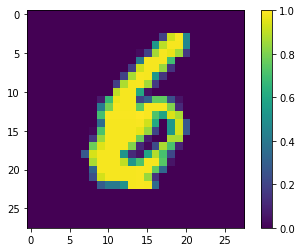

In [21]:
ix=129
x,y = train_dataset[ix]
plt.imshow(x.squeeze().numpy())
plt.colorbar()
print('label: y={}'.format(y))

Now let's define the dataloaders and train simple neural network like before.
You'll recognize that the core is exactly the same: we do a forward pass, compute a loss, backpropagate the loss to compute the gradients, then let the optimizer update the weights.

In [22]:
# The neural network hyperparameters.
input_size    = 784   # The MNIST image size = 28 x 28 = 784
hidden_size   = 100   # The number of nodes at the hidden layer
num_classes   = 10    # The number of output classes. In this case, from 0 to 9
num_epochs    = 5     # The number of times entire dataset is trained
batch_size    = 100   # The number of samples per minibatch
learning_rate = 1.0   # SGD step size

In [23]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [24]:
len(train_loader)

600

In [25]:
device = torch.device('cpu') # if on gpu-enabled machine, change to torch.device('cuda')

#  define simple neural network with 1 hidden layer.
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
        self.relu = nn.ReLU()                          # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = nn.Linear(hidden_size, num_classes) # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)
    
    def forward(self, x):                              # Forward pass: stacking each layer together
        x = x.view(x.size(0), -1) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
def test(net, dl):
    right, tot = 0, 0
    net.eval() # Set dropout and possibly other modules in eval mode.
    for x,y in dl:
        ypred = net(x).argmax(dim=1) # select index of maximal score
        right += (ypred == y).sum().item()
        tot   += x.size(0)
    return 1.* right / tot

In [26]:
# create the net based on this class definition
net = Net(input_size, hidden_size, num_classes).to(device)
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
print('Before training: {:.1f}% test accuracy'.format(100*test(net, test_loader)))
for epoch in range(num_epochs):
    scheduler.step()
    for i, (x,y_target) in enumerate(train_loader):
        x, y_target = x.to(device), y_target.to(device)
        y_probs = F.log_softmax(net(x), dim=1)
        output = F.nll_loss(y_probs, y_target)
        output.backward()
        optimizer.step()
        net.zero_grad()
    print('After epoch {}: {:.1f}% test accuracy'.format(epoch, 100*test(net, test_loader)))
print('End of training: {:.1f}% train accuracy'.format(100*test(net, train_loader)))

Before training: 11.2% test accuracy
After epoch 0: 95.4% test accuracy
After epoch 1: 96.5% test accuracy
After epoch 2: 97.1% test accuracy
After epoch 3: 97.3% test accuracy
After epoch 4: 97.3% test accuracy
End of training: 98.1% train accuracy


Ground truth label: y=8
Model probabilities: 
0: 0.047 / 1: 0.000 / 2: 0.206 / 3: 0.018 / 4: 0.000 / 5: 0.012 / 6: 0.027 / 7: 0.000 / 8: 0.690 / 9: 0.000
Model prediction:  tensor([8])


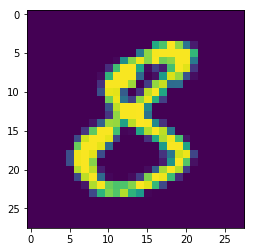

In [27]:
# show the prediction on some samples.
ix=1234
x,y = test_dataset[ix]
plt.imshow(x.squeeze().numpy())
print('Ground truth label: y={}'.format(y))
y_probs = F.softmax(net(x), dim=1)
print ('Model probabilities: ') 
print(' / '.join(['{}: {:.3f}'.format(k,v) 
                  for k,v in zip(range(10), y_probs.squeeze().tolist()) ] ))
print('Model prediction: ', y_probs.argmax(1))

Voila and that's how it's done. You can play around to figure out the answer to some more questions:
* What do we get back from `net.parameters()`: which trainable weights and biases does the network have now? 
* How many total parameters?
* Can you add another hidden layer to the class definition of `Net`? How does the performance change (watch both test & train)?
* Can you add a dropout layer after the first and second hidden layer? How does performance change now? See https://pytorch.org/docs/master/nn.html#torch.nn.Dropout


Some more fundamental questions for you to understand what's going on in the optimization loop:
* what does softmax do? (compute softmax of a random vector, then sum the output, it will sum to 1)
* what is its purpose? (read the docs)
* what does nll_loss compute? can you manually compute it?

Important questions to revisit after you learned about overfitting:
* How many parameters (weights) does our classifier neural network have? How many  datapoints did we train on?
* Old-skool machine learning rule of thumb is: you can optimize about as many parameters (weights) as you have datapoints before you can memorize the dataset (thus overfit heavily). Are we close to the limit?
* Does the model overfit? We are measuring this by splitting off a heldout set after loading the data on which you do not train, and measure performance on the heldout set.
* In deep neural networks you can easily have way more parameters than datapoints. Is overfitting an issue for neural networks in general?

Now we used a simple flat neural network which looks at the image as a flat vector, without awareness of the 2D structure or which pixels neighbor each other.
A convolutional neural network is an architecture that takes the 2D structure of the image into account by sliding a kernel over all the different locations in the image. This kind of neural network has been very succesful in image recognition [1] and speech recognition [2,3].
Pytorch and other deep learning toolboxes are designed to deal with this kind of data and with convolutional neural networks just as easily as with flat data. Try swapping out the network above for a convolutional neural network, see for example the pytorch tutorial [4].

[1] https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks
[2] http://www.cs.toronto.edu/~asamir/papers/icassp13_cnn.pdf
[3] https://arxiv.org/abs/1509.08967
[4] https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
[5] https://colab.research.google.com/drive/1jxUPzMsAkBboHMQtGyfv5M5c7hU8Ss2c

In [ ]:
# have fun exploring

# Finishing notes

Inspiration for this lab and the lecture:

*  An old lab I made in lua torch https://github.com/tomsercu/torchtutorial
* This pytorch intro notebook https://colab.research.google.com/drive/1jxUPzMsAkBboHMQtGyfv5M5c7hU8Ss2c
* The official pytorch tutorial https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
* Yann LeCuns deep learning course in 2015 https://cilvr.nyu.edu/doku.php?id=deeplearning2015:schedule
